In [1]:
#importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
X = pd.read_csv('../Datasets/NB.csv')
X['Fault'] = 0

y = pd.read_csv('../Datasets/IR - 21.csv')
y['Fault'] = 1

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size = 0.2, shuffle=False, random_state = 0)

y_train, y_test = train_test_split(y, test_size = 0.2, shuffle=False, random_state = 0)

In [4]:
train = X_train.append(y_train)
train = train.reset_index(drop=True)
train

,DE,FE,Fault
0,0.064254,0.038625,0
1,0.063002,0.096769,0
2,-0.004381,0.127382,0
3,-0.035882,0.144640,0
4,-0.023991,0.086702,0
...,...,...,...
193843,0.075532,0.038625,1
193844,0.135633,-0.050747,1
193845,-0.041421,0.081155,1
193846,-0.097461,0.054445,1


In [5]:
test = X_test.append(y_test)
test = test.reset_index(drop=True)
test

,DE,FE,Fault
0,0.058204,-0.015204,0
1,0.011057,0.005958,0
2,-0.066548,0.066362,0
3,-0.131845,0.110535,0
4,-0.132471,0.096153,0
...,...,...,...
48457,0.041421,-0.061431,1
48458,0.079187,0.121218,1
48459,-0.083654,0.120807,1
48460,-0.031269,-0.092865,1


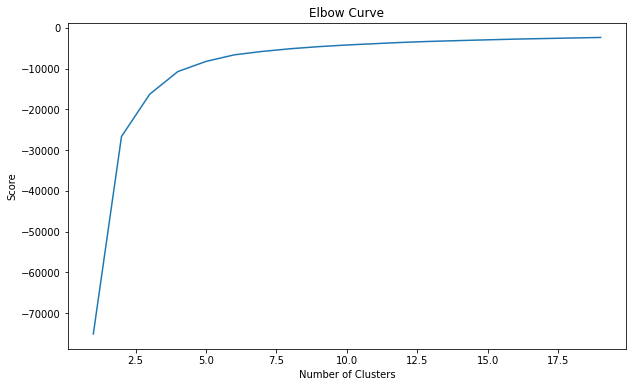

In [6]:
from sklearn.cluster import KMeans

train_data = train[['DE', 'FE', 'Fault']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(train_data) for i in n_cluster]
scores = [kmeans[i].score(train_data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

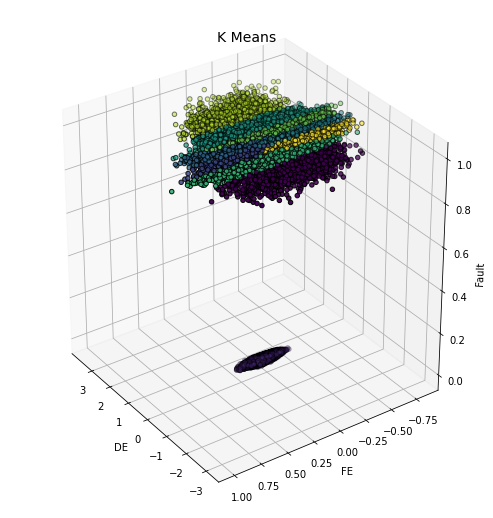

In [7]:
from mpl_toolkits.mplot3d import Axes3D

X = train[['DE', 'FE', 'Fault']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=30, azim=145)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("DE")
ax.set_ylabel("FE")
ax.set_zlabel("Fault")
plt.title("K Means", fontsize=14);

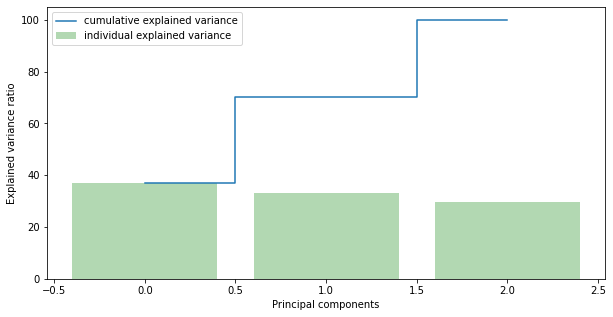

In [8]:
from sklearn.preprocessing import StandardScaler

train_data = train[['DE', 'FE', 'Fault']]

X = train_data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [9]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(train_data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
train['anomaly'] = (distance >= threshold).astype(int)

C:\Users\leste\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


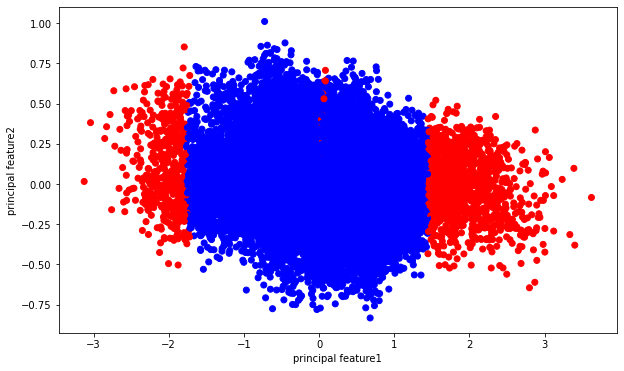

In [10]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(train['DE'], train['FE'], c=train["anomaly"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

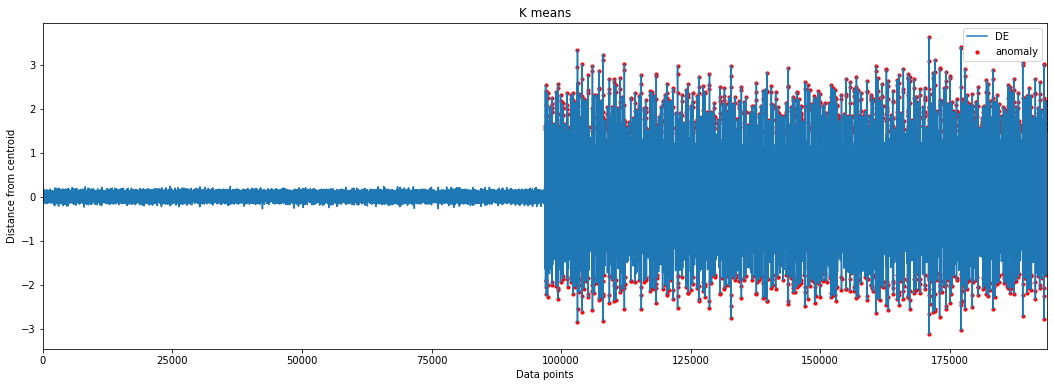

In [11]:
train_anomalies = train[train['anomaly'] == 1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(train_anomalies.index, train_anomalies.DE, label='anomaly', color='red', s=10)
ax1.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('K means')
plt.xlabel('Data points')
plt.ylabel('Distance from centroid')
plt.legend();
plt.show();

In [12]:
train_anomalies

,DE,FE,Fault,anomaly
96930,1.610950,-0.014176,1,1
96934,1.530951,-0.016231,1,1
97002,2.400385,0.119369,1,1
97004,-2.044246,0.539524,1,1
97006,2.540079,-0.345985,1,1
...,...,...,...,...
193582,1.965059,-0.156556,1,1
193583,2.082418,-0.287225,1,1
193586,1.885872,0.253942,1,1
193587,2.171352,0.024244,1,1


In [13]:
test_data = test[['DE', 'FE', 'Fault']]
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(test_data, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
test['anomaly'] = (distance >= threshold).astype(int)

C:\Users\leste\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


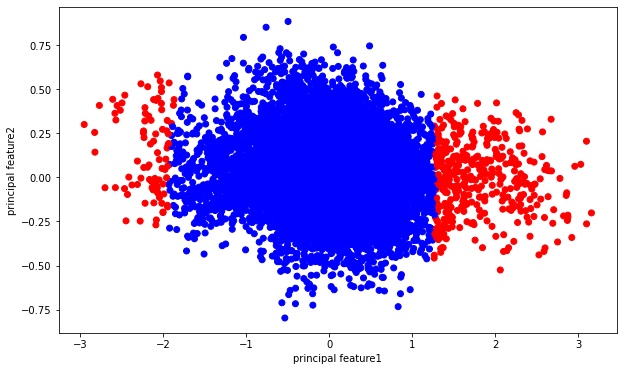

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(test['DE'], test['FE'], c=test["anomaly"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();

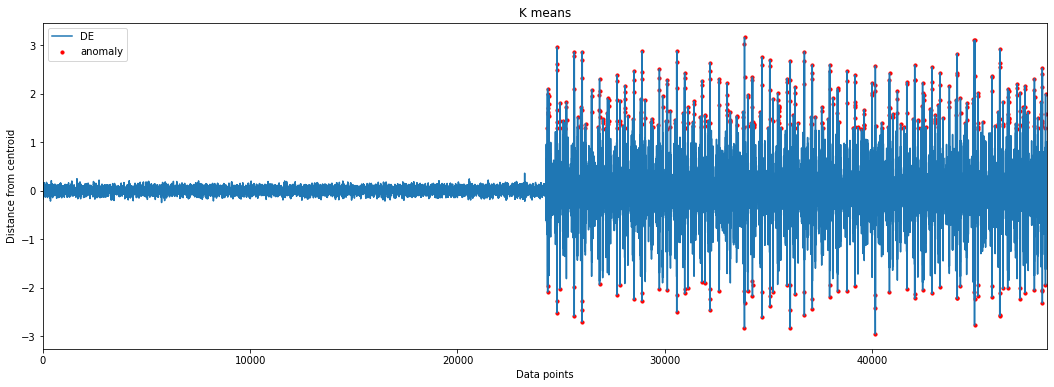

In [15]:
test_anomalies = test[test['anomaly'] == 1]

f, (ax2) = plt.subplots(figsize=(18, 6))
ax2.scatter(test_anomalies.index, test_anomalies.DE, label='anomaly', color='red', s=10)
ax2.plot(test.index, test.DE, label='DE');
plt.xlim((0,len(test.index)))

plt.title('K means')
plt.xlabel('Data points')
plt.ylabel('Distance from centroid')
plt.legend();
plt.show();

In [16]:
test_anomalies

,DE,FE,Fault,anomaly
24342,1.282831,-0.187785,1,1
24345,1.706787,-0.260516,1,1
24346,1.997140,0.158611,1,1
24348,-1.956125,0.166418,1,1
24349,1.571154,0.245107,1,1
...,...,...,...,...
48227,1.439175,-0.147516,1,1
48370,1.289735,-0.290102,1,1
48372,-1.940288,0.246751,1,1
48374,1.988612,0.226411,1,1


In [17]:
from sklearn.metrics import accuracy_score
score = 100 * accuracy_score(test['anomaly'], test['Fault'])
print("Accuracy: {:.2f}%".format(score))

Accuracy: 51.00%


In [18]:
print("Anomalies: {}".format(test_anomalies['anomaly'].count()))

Anomalies: 484
